In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from einops import rearrange
from timm.models.vision_transformer import Block
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

data_dir = "/kaggle/input/nturgbd-skeletons-s001-to-s017/nturgb+d_skeletons"  
missing_samples_file = "/kaggle/input/ntu-missing-skeleton/NTU_RGBD_samples_with_missing_skeletons.txt"

categories = [
    "drink water", "eat meal/snack", "brushing teeth", "brushing hair", "drop", "pickup", "throw", "sitting down", 
    "standing up (from sitting position)", "clapping", "reading", "writing", "tear up paper", "wear jacket", "take off jacket", 
    "wear a shoe", "take off a shoe", "wear on glasses", "take off glasses", "put on a hat/cap", "take off a hat/cap", "cheer up", 
    "hand waving", "kicking something", "reach into pocket", "hopping (one foot jumping)", "jump up", "make a phone call/answer phone", 
    "playing with phone/tablet", "typing on a keyboard", "pointing to something with finger", "taking a selfie", "check time (from watch)", 
    "rub two hands together", "nod head/bow", "shake head", "wipe face", "salute", "put the palms together", "cross hands in front (say stop)", 
    "sneeze/cough", "staggering", "falling", "touch head (headache)", "touch chest (stomachache/heart pain)", "touch back (backache)", 
    "touch neck (neckache)", "nausea or vomiting condition", "use a fan (with hand or paper)/feeling warm", "punching/slapping other person", 
    "kicking other person", "pushing other person", "pat on back of other person", "point finger at the other person", "hugging other person", 
    "giving something to other person", "touch other person's pocket", "handshaking", "walking towards each other", "walking apart from each other"
]
category_to_label = {category: idx for idx, category in enumerate(categories)}

In [4]:
missing_samples = set()
with open(missing_samples_file, 'r') as f:
    missing_samples = set(line.strip() for line in f.readlines())

In [5]:
class NTURGBDSkeletonDataset(Dataset):
    def __init__(self, data_dir, transform=None, frames_per_clip=16):
        self.data_dir = data_dir
        self.transform = transform
        self.frames_per_clip = frames_per_clip
        self.data = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for file_name in os.listdir(self.data_dir):
            if not file_name.endswith('.skeleton') or file_name[:-9] in missing_samples:
                continue

            action_label = file_name.split('A')[-1][:3]
            if not action_label.isdigit() or int(action_label) < 1 or int(action_label) > 60:
                continue

            file_path = os.path.join(self.data_dir, file_name)
            skeleton_data = self._parse_skeleton_file(file_path)
            if skeleton_data is not None:
                self.data.append(skeleton_data)
                self.labels.append(int(action_label) - 1)

    def _parse_skeleton_file(self, file_path):
        try:
            with open(file_path, 'r') as f:
                lines = f.readlines()
                
            num_frames = int(lines[0].strip())
            frames = []
            idx = 1
            
            for _ in range(num_frames):
                if idx >= len(lines):
                    return None
                
                try:
                    num_skeletons = int(lines[idx].strip())
                except ValueError:
                    return None
                
                idx += 1
                if num_skeletons == 0:
                    continue

                idx += 2  
                joints = []
                
                for _ in range(25):
                    if idx >= len(lines):
                        return None
                    
                    joint_info = lines[idx].strip().split()
                    if len(joint_info) < 3:
                        return None
                    
                    try:
                        joints.append([float(joint_info[0]), float(joint_info[1]), float(joint_info[2])])
                    except ValueError:
                        return None
                    
                    idx += 1
                
                frames.append(np.array(joints))

            frames = np.array(frames)
            if len(frames) < self.frames_per_clip:
                return None
            
            indices = np.linspace(0, len(frames) - 1, self.frames_per_clip, dtype=int)
            return frames[indices]
        
        except Exception:
            return None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [6]:
dataset = NTURGBDSkeletonDataset(data_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print(f"Dataset Loaded: {len(dataset)} samples")

Dataset Loaded: 44888 samples


In [8]:
import torch
import torch.nn as nn
from einops import rearrange
from timm.models.vision_transformer import Block

class TimeSformer4(nn.Module):
    def __init__(self, input_dim=3, embed_dim=256, num_heads=8, depth=6, num_classes=60):
        super(TimeSformer4, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

        self.position_embedding = nn.Parameter(torch.randn(1, 400, embed_dim))  

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.3)
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, T, J, C = x.size()  

        x = self.embedding(x)  
        x = rearrange(x, 'b t j d -> b (t j) d')  

        pos_embed = self.position_embedding[:, :x.shape[1], :]
        x = x + pos_embed

        cls_tokens = self.cls_token.expand(B, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1)  
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x[:, 0])  
        x = self.head(x)
        return x

In [27]:
num_epochs4 = 30
accumulation_steps = 2

In [28]:
import time
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_model2(model, train_loader, val_loader, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs4)
    scaler = torch.amp.GradScaler()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    history = {
        "epochs4": [],
        "train_loss4": [],
        "train_acc4": [],
        "val_loss4": [],
        "val_acc4": [] 
    }

    print(f"\n Training {model_name}...\n")

    total_training_time = time.time()  

    for epoch in range(num_epochs4):
        start_time = time.time()  

        model.train()
        total_loss, correct_train, total_train = 0, 0, 0

        optimizer.zero_grad()
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs4}", leave=True)

        for batch_idx, (inputs, labels) in enumerate(train_progress):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with torch.amp.autocast("cuda"):  
                outputs = model(inputs)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.detach().cpu().item() * accumulation_steps
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += labels.size(0)

            train_progress.set_postfix(loss=loss.detach().cpu().item() * accumulation_steps)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with torch.amp.autocast("cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss += loss.detach().cpu().item()
                correct_val += (outputs.argmax(dim=1) == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        scheduler.step()

        epoch_time = time.time() - start_time  

        history["epochs4"].append(epoch + 1)
        history["train_loss4"].append(avg_train_loss)
        history["train_acc4"].append(train_accuracy)
        history["val_loss4"].append(avg_val_loss)
        history["val_acc4"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs4}: "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
              f"Time: {epoch_time:.2f}s")

    total_training_time = time.time() - total_training_time  

    model_save_path = f"/kaggle/working/{model_name}.pth"
    torch.save({"model_state_dict": model.state_dict(), "history": history}, model_save_path)
    print(f"\n Model {model_name} saved at: {model_save_path}")
    print(f"Total training time for {model_name}: {total_training_time:.2f}s")

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timesformer4 = TimeSformer4().to(device)

In [ ]:
train_model2(timesformer4, train_loader, val_loader, "TimeSformer4-NTU")


 Training TimeSformer4-NTU...



Epoch 1/30: 100%|██████████| 8978/8978 [02:32<00:00, 58.72it/s, loss=3.61]


Epoch 1/30: Train Loss: 4.0108 | Train Acc: 0.0241 | Val Loss: 3.8298 | Val Acc: 0.0342 | Time: 165.42s


Epoch 2/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.13it/s, loss=3.29]


Epoch 2/30: Train Loss: 3.5323 | Train Acc: 0.0927 | Val Loss: 3.1449 | Val Acc: 0.2054 | Time: 164.76s


Epoch 3/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.35it/s, loss=2.64]


Epoch 3/30: Train Loss: 2.9689 | Train Acc: 0.2434 | Val Loss: 2.7462 | Val Acc: 0.3062 | Time: 164.47s


Epoch 4/30: 100%|██████████| 8978/8978 [02:33<00:00, 58.31it/s, loss=1.59]


Epoch 4/30: Train Loss: 2.7097 | Train Acc: 0.3183 | Val Loss: 2.6074 | Val Acc: 0.3497 | Time: 166.56s


Epoch 5/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.07it/s, loss=2.3]  


Epoch 5/30: Train Loss: 2.5998 | Train Acc: 0.3482 | Val Loss: 2.5628 | Val Acc: 0.3568 | Time: 164.44s


Epoch 6/30: 100%|██████████| 8978/8978 [02:40<00:00, 56.07it/s, loss=3.03] 


Epoch 6/30: Train Loss: 2.4883 | Train Acc: 0.3811 | Val Loss: 2.3934 | Val Acc: 0.4096 | Time: 172.99s


Epoch 7/30: 100%|██████████| 8978/8978 [02:40<00:00, 55.94it/s, loss=1.14] 


Epoch 7/30: Train Loss: 2.4678 | Train Acc: 0.3902 | Val Loss: 2.4318 | Val Acc: 0.3986 | Time: 173.46s


Epoch 8/30: 100%|██████████| 8978/8978 [02:39<00:00, 56.18it/s, loss=2.41] 


Epoch 8/30: Train Loss: 2.4111 | Train Acc: 0.4036 | Val Loss: 2.2946 | Val Acc: 0.4541 | Time: 172.68s


Epoch 9/30: 100%|██████████| 8978/8978 [02:41<00:00, 55.65it/s, loss=2.76] 


Epoch 9/30: Train Loss: 2.3652 | Train Acc: 0.4173 | Val Loss: 2.3617 | Val Acc: 0.4285 | Time: 173.95s


Epoch 10/30: 100%|██████████| 8978/8978 [02:40<00:00, 55.94it/s, loss=3.17] 


Epoch 10/30: Train Loss: 2.3770 | Train Acc: 0.4162 | Val Loss: 2.3073 | Val Acc: 0.4339 | Time: 173.24s


Epoch 11/30: 100%|██████████| 8978/8978 [02:41<00:00, 55.70it/s, loss=2.42] 


Epoch 11/30: Train Loss: 2.3078 | Train Acc: 0.4373 | Val Loss: 2.2301 | Val Acc: 0.4669 | Time: 174.04s


Epoch 14/30: 100%|██████████| 8978/8978 [02:30<00:00, 59.51it/s, loss=1.79] 


Epoch 14/30: Train Loss: 2.1834 | Train Acc: 0.4786 | Val Loss: 2.1256 | Val Acc: 0.5042 | Time: 163.68s


Epoch 15/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.35it/s, loss=2.11] 


Epoch 15/30: Train Loss: 2.1444 | Train Acc: 0.4918 | Val Loss: 2.1233 | Val Acc: 0.4986 | Time: 164.12s


Epoch 18/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.34it/s, loss=2.35] 


Epoch 18/30: Train Loss: 2.0683 | Train Acc: 0.5160 | Val Loss: 2.0491 | Val Acc: 0.5321 | Time: 163.83s


Epoch 21/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.33it/s, loss=1.05] 


Epoch 21/30: Train Loss: 1.9624 | Train Acc: 0.5549 | Val Loss: 2.0336 | Val Acc: 0.5363 | Time: 163.83s


Epoch 22/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.36it/s, loss=1.6]  


Epoch 22/30: Train Loss: 1.9352 | Train Acc: 0.5642 | Val Loss: 2.0022 | Val Acc: 0.5472 | Time: 164.11s


Epoch 25/30: 100%|██████████| 8978/8978 [02:30<00:00, 59.56it/s, loss=1.45] 


Epoch 25/30: Train Loss: 1.8653 | Train Acc: 0.5877 | Val Loss: 1.9745 | Val Acc: 0.5622 | Time: 163.57s


Epoch 29/30: 100%|██████████| 8978/8978 [02:31<00:00, 59.45it/s, loss=0.93] 


Epoch 29/30: Train Loss: 1.8184 | Train Acc: 0.6051 | Val Loss: 1.9560 | Val Acc: 0.5696 | Time: 163.59s


Epoch 30/30:  34%|███▍      | 3050/8978 [00:51<01:38, 60.25it/s, loss=1.96] 

In [31]:
his3 = torch.load("TimeSformer4-NTU.pth", weights_only=False)  
his_data = his3["history"]  

epochs4 = his_data["epochs4"]
train_loss4 = his_data["train_loss4"]
train_acc4 = his_data["train_acc4"]
val_loss4 = his_data["val_loss4"]
val_acc4 = his_data["val_acc4"]

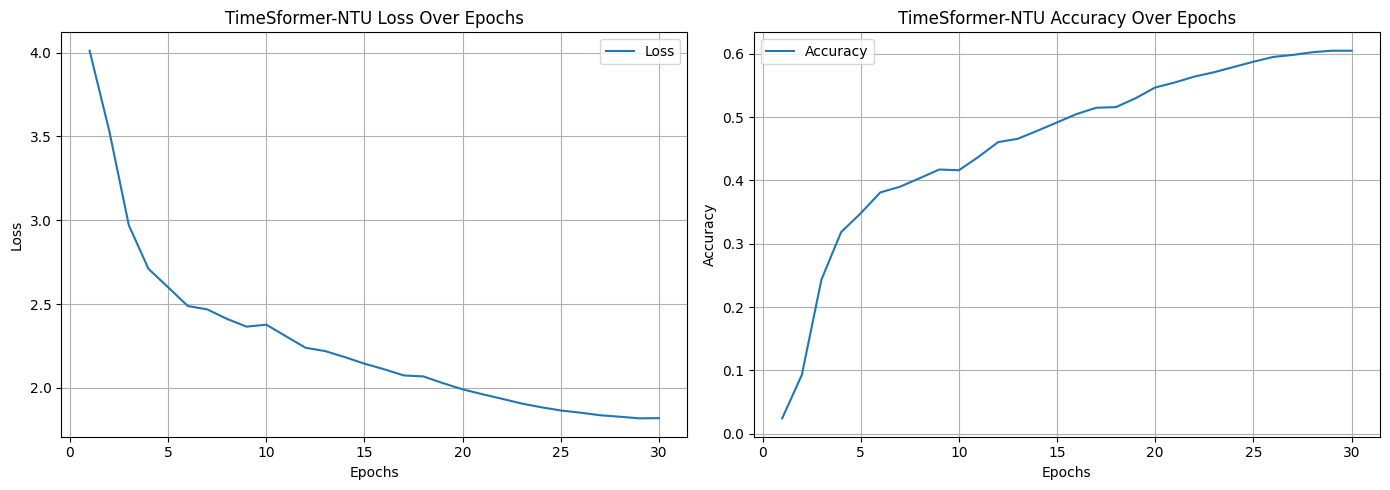

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(epochs4, train_loss4, label="Loss", linestyle='-')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("TimeSformer-NTU Loss Over Epochs")
ax[0].legend()
ax[0].grid()

ax[1].plot(epochs4, train_acc4, label="Accuracy", linestyle='-')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("TimeSformer-NTU Accuracy Over Epochs")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [33]:
his_data

{'epochs4': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 'train_loss4': [4.010759234534629,
  3.5323336608268074,
  2.968904544885452,
  2.7096965332343546,
  2.599758397745486,
  2.4883031316498228,
  2.467820986517821,
  2.411069782818843,
  2.365211235179644,
  2.3770303428239457,
  2.3078358832354215,
  2.2392190350777694,
  2.2194255150673676,
  2.1834313432897856,
  2.1444451048435784,
  2.11110704358502,
  2.074278681600617,
  2.068314556031589,
  2.028280632403997,
  1.9913808794044445,
  1.962355598266259,
  1.9351604104334168,
  1.906942486258439,
  1.8844946925253452,
  1.8653062128242603,
  1.8521847753794056,
  1.8369952720359854,
  1.8280369296361247,
  1.8184221755704095,
  1.819548305762215],
 'train_acc4': [0.024115845168476747,
  0.09270398217766639,
  0.24341409078251183,
  0.3182678919521025,
  0.3482316903369535,
  0.38114731272626007,
  0.

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

wtmr_history2 = torch.load("/kaggle/input/ntu60models/WTMRNet_NTU_RGBD60.pth", map_location="cpu", weights_only=False)
wmrc_history2 = torch.load("/kaggle/input/ntu60models/MultiRegionCNN4.pth", map_location="cpu", weights_only=False)
timesformer_history2 = torch.load("/kaggle/input/ntu60models/TimeSformer4-NTU.pth", map_location="cpu", weights_only=False)

In [26]:
wtmr_train_loss2 = wtmr_history2["historyn"]["train_loss3"][-1]
wtmr_train_acc2 = wtmr_history2["historyn"]["train_acc3"][-1]

wmrc_train_loss2 = wmrc_history2["historyn"]["train_loss4"][-1]
wmrc_train_acc2 = wmrc_history2["historyn"]["train_acc4"][-1]

timesformer_train_loss2 = timesformer_history2["history"]["train_loss4"][-1]
timesformer_train_acc2 = timesformer_history2["history"]["train_acc4"][-1]

In [27]:
models = ["WTMR-Net_NTU", "WMRC-Net_NTU", "TimeSformer_NTU"]
train_losses = [wtmr_train_loss2, wmrc_train_loss2, timesformer_train_loss2]
train_accuracies = [wtmr_train_acc2, wmrc_train_acc2, timesformer_train_acc2]

x = np.arange(len(models))
width = 0.5

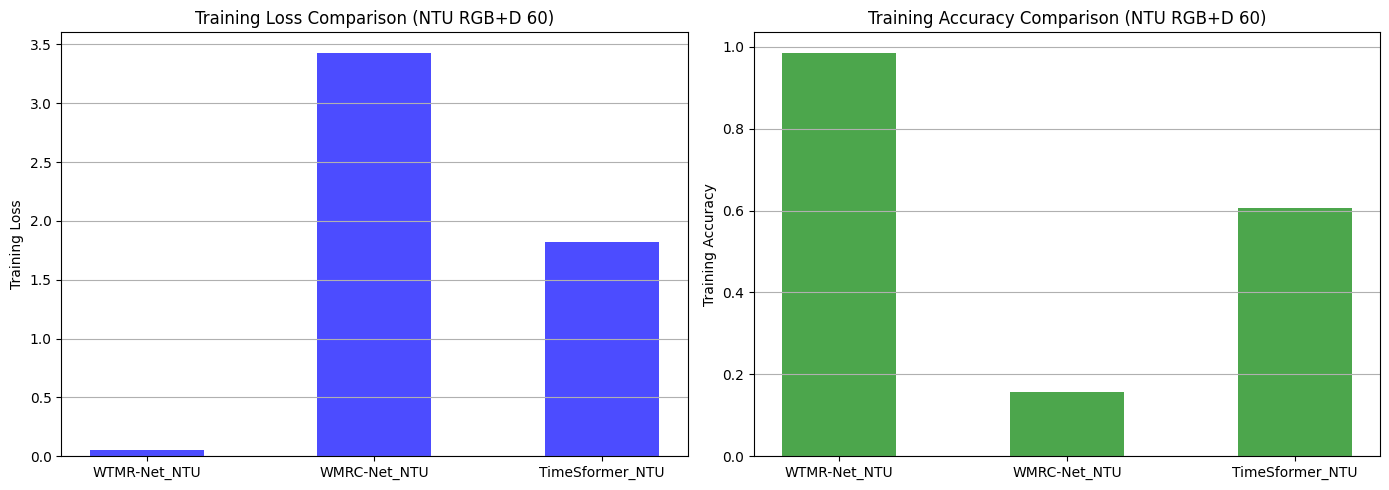

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].bar(x, train_losses, width, color='blue', alpha=0.7)
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].set_ylabel("Training Loss")
ax[0].set_title("Training Loss Comparison (NTU RGB+D 60)")
ax[0].grid(axis='y')

ax[1].bar(x, train_accuracies, width, color='green', alpha=0.7)
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].set_ylabel("Training Accuracy")
ax[1].set_title("Training Accuracy Comparison (NTU RGB+D 60)")
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()